In [1]:
from google.colab import drive
drive.mount('/content/drive/')
# drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [2]:
# Install monai
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 88.1 MB/s eta 0:00:00


Renaming the files

In [3]:
# Import libraries
import os
import shutil
import tempfile
import json
import random
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nibabel as nib

from monai.losses import DiceCELoss, TverskyLoss
from monai.inferers import sliding_window_inference, SlidingWindowInferer, SliceInferer
from monai.utils import set_determinism, first
from monai.transforms import (
    AsDiscrete,
    Activations,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Lambda,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    ScaleIntensity,
    Spacingd,
    SpatialPad,
    SpatialPadd,
    SqueezeDimd,
    RandRotate90d,
    RandBiasFieldd,
    RandAdjustContrastd,
    RandGaussianNoised,
    ResizeWithPadOrCropd,
    RandAffined,
    ToTensord,
    Resize,
    Resized,
    EnsureTyped,
    AsDiscreted,
    RandGaussianSharpend,
    RandFlipd,
    RandRotated,
    RandZoomd,
    Rand3DElasticd

)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNet

from monai.data import (
    CacheDataset, DataLoader, load_decathlon_datalist, PatchIterd,
    GridPatchDataset, ShuffleBuffer, decollate_batch
)

import torch
from glob import glob
# print_config()


# switch off warning messages
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
import json
import random
from glob import glob

# Set random seed for reproducibility
random.seed(42)

# Define paths
image_dir = "/content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/"
label_dir = "/content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/refined-labelsTr/"

# Get sorted lists of images and labels
image_files = sorted(glob(os.path.join(image_dir, "*.nii.gz")))
label_files = sorted(glob(os.path.join(label_dir, "*.nii.gz")))

print(len(image_files))
print(len(label_files))

# Ensure correct pairing
assert len(image_files) == len(label_files), "Mismatch between image and label counts."

# Extract just the filenames (without full paths)
image_names = [os.path.basename(img) for img in image_files]

# Pair images and labels
data_pairs = [{"image": f"mibirth_training/imagesTr/{img}", "label": f"mibirth_training/refined-labelsTr/{img}"} for img in image_names]

# Shuffle dataset
random.shuffle(data_pairs)

# Split dataset: 80% train, 20% validation
num_total = len(data_pairs)
num_train = int(0.8 * num_total)
num_val = num_total - num_train  # Remaining as validation

train_data = data_pairs[:num_train]
val_data = data_pairs[num_train:]

# Create JSON structure
dataset_json = {
    "description": "2D MRI Fetal Segmentation Dataset",
    "modality": {"0": "MRI"},
    "name": "fetal_mri_dataset",
    "numTraining": len(train_data),
    "numValidation": len(val_data),
    "reference": "KCL",
    "release": "1.0",
    "tensorImageSize": "2D",
    "labels": {
        "0": "background",
        "1": "class_1",
        "2": "class_2",
        "3": "class_3",
        "4": "class_4",
        "5": "class_5"
    },
    "training": train_data,
    "validation": val_data
}

# Save JSON file
json_path = "/content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/2d_dataset.json"
with open(json_path, "w") as json_file:
    json.dump(dataset_json, json_file, indent=4)

print(f"✅ Dataset JSON saved to {json_path}")

102
102
✅ Dataset JSON saved to /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/2d_dataset.json


In [4]:
# Define paths
image_dir = "/content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/"
label_dir = "/content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/refined-labelsTr/"

# Get sorted lists of images and labels
image = sorted(glob(os.path.join(image_dir, "*.nii.gz")))
label = sorted(glob(os.path.join(label_dir, "*.nii.gz")))

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths
data_dir = '/content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation'
split_JSON = "dataset.json"
datasets = os.path.join(data_dir, split_JSON)

# Load dataset
train_files = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")

Resize Images to (256, 256, 96)

Normalize all images to a smaller size (recommended for deep learning training):

The error message AttributeError: 'dict' object has no attribute 'shape' indicates that the SpatialPad transform is expecting an input with a shape attribute (like a NumPy array or a PyTorch tensor), but it's receiving a dictionary instead. This is likely happening because the SpatialPad transform is being applied before the data has been converted to a tensor using the ToTensord transform.

Since the SpatialPad transform is still causing issues even after moving ToTensord before it, it might be due to the way padding is calculated. It is likely because of the variable size of the images.

Instead of using SpatialPad, we can use ResizeWithPadOrCropd, which handles resizing and padding (or cropping if needed) in a single step. This should resolve the error by performing padding in a way that's compatible with the data after it's converted to a tensor.

In [6]:
from monai.transforms import Lambdad

def combine_fetus_labels(label):
    label = label.clone()
    label[label == 5] = 1
    return label

In [7]:
# rotation degree (Rad)
degree_min = -2.05
degree_max = 2.05
target_size = [128, 128, 128]

train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Lambdad(keys="label", func=combine_fetus_labels),
    Spacingd(keys=["image", "label"], pixdim=(0.8, 0.8, 4.0), mode=("bilinear", "nearest")),
    SpatialPadd(keys=["image", "label"], spatial_size=target_size, method="symmetric"),
    Resized(keys=["image", "label"], spatial_size=target_size, mode=("trilinear", "nearest")),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1002, b_min=0.0, b_max=1.0, clip=True),
    RandAffined(
        keys=["image", "label"],
        rotate_range=[(degree_min,degree_max),(degree_min,degree_max),(degree_min,degree_max)],
        mode=("bilinear", "nearest"),
        padding_mode=("zeros"),
        prob=0.70,
    ),
    ToTensord(keys=["image", "label"]),
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Lambdad(keys="label", func=combine_fetus_labels),
    Spacingd(keys=["image", "label"], pixdim=(0.8, 0.8, 4.0), mode=("bilinear", "nearest")),
    SpatialPadd(keys=["image", "label"], spatial_size=target_size, method="symmetric"),
    Resized(keys=["image", "label"], spatial_size=target_size, mode=("trilinear", "nearest")),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1002, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=["image", "label"]),
])

In [8]:
# 3D dataset with preprocessing transforms - train
train_volume_ds = CacheDataset(data=train_files, transform=train_transforms)
# use batch_size=1 to check the volumes because the input volumes have different shapes
train_check_loader = DataLoader(train_volume_ds, batch_size=1)
train_check_data = first(train_check_loader)
print("first volume's shape: ", train_check_data["image"].shape, train_check_data["label"].shape)

# 3D dataset with preprocessing transforms - validation
val_volume_ds = CacheDataset(data=val_files, transform=val_transforms)
# use batch_size=1 to check the volumes because the input volumes have different shapes
val_check_loader = DataLoader(val_volume_ds, batch_size=1)
val_check_data = first(val_check_loader)
print("first volume's shape: ", val_check_data["image"].shape, val_check_data["label"].shape)

Loading dataset: 100%|██████████| 144/144 [07:51<00:00,  3.28s/it]


first volume's shape:  torch.Size([1, 1, 128, 128, 128]) torch.Size([1, 1, 128, 128, 128])


Loading dataset: 100%|██████████| 37/37 [02:01<00:00,  3.30s/it]

first volume's shape:  torch.Size([1, 1, 128, 128, 128]) torch.Size([1, 1, 128, 128, 128])


If output is [0, 1] → Binary segmentation (foreground vs background)
- Set: lab_num = 1, class_num = 2

If output is [0, 1, 2, 3] → Multi-class segmentation
- Set: lab_num = 3, class_num = 4

Segmentation masks contain the values:
[0, 1, 2, 3, 4, 5]

This means:
- 0 → Background
- 1, 2, 3, 4, 5 → 5 foreground classes

In [10]:
patch_func = PatchIterd(
    keys=["image", "label"],
    patch_size=(128, 128, 1),  # dynamic first two dimensions
    start_pos=(0, 0, 0)
)
patch_transform = Compose(
    [
        SqueezeDimd(keys=["image", "label"], dim=-1),  # squeeze the last dim
        Resized(keys=["image", "label"], spatial_size=[128, 128]),
    ]
)

# train
train_patch_ds = GridPatchDataset(
    data=train_volume_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False)
train_loader = DataLoader(
    train_patch_ds,
    batch_size=5,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
)
train_check_data = first(train_loader)

# validation
val_patch_ds = GridPatchDataset(
    data=val_volume_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False)
val_loader = DataLoader(
    val_patch_ds,
    batch_size=5,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
)
val_check_data = first(val_loader)

In [11]:
# Check transformed shapes
def check_transformed_shapes(dataloader, dataset_name):
    print(f"\nChecking {dataset_name} dataset shapes after transformation:")
    for i, batch in enumerate(dataloader):
        image, label = batch["image"], batch["label"]
        print(f"Sample {i}: Image shape {image.shape}, Label shape {label.shape}")
        if i == 4:
            break  # Check first 5 samples

check_transformed_shapes(train_loader, "Training")
check_transformed_shapes(val_loader, "Validation")


Checking Training dataset shapes after transformation:
Sample 0: Image shape torch.Size([5, 1, 128, 128]), Label shape torch.Size([5, 1, 128, 128])
Sample 1: Image shape torch.Size([5, 1, 128, 128]), Label shape torch.Size([5, 1, 128, 128])
Sample 2: Image shape torch.Size([5, 1, 128, 128]), Label shape torch.Size([5, 1, 128, 128])
Sample 3: Image shape torch.Size([5, 1, 128, 128]), Label shape torch.Size([5, 1, 128, 128])
Sample 4: Image shape torch.Size([5, 1, 128, 128]), Label shape torch.Size([5, 1, 128, 128])

Checking Validation dataset shapes after transformation:
Sample 0: Image shape torch.Size([5, 1, 128, 128]), Label shape torch.Size([5, 1, 128, 128])
Sample 1: Image shape torch.Size([5, 1, 128, 128]), Label shape torch.Size([5, 1, 128, 128])
Sample 2: Image shape torch.Size([5, 1, 128, 128]), Label shape torch.Size([5, 1, 128, 128])
Sample 3: Image shape torch.Size([5, 1, 128, 128]), Label shape torch.Size([5, 1, 128, 128])
Sample 4: Image shape torch.Size([5, 1, 128, 128]

Define the network using MONAI

In [12]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2D UNet
model = UNet(spatial_dims=2,
in_channels=1,
out_channels=5,
channels=(32, 64, 128, 256, 512),
strides=(2,2,2,2),
kernel_size=3,
up_kernel_size=3,
num_res_units=1,
act='PRELU',
norm='INSTANCE',
dropout=0.5).to(device)

# define the loss and optimiser
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=0.7, lambda_ce=0.3)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [13]:
qq=64
alpha_val = 0.4
def show_image(img, logit_map, qq):
    plt.figure("cnn output", (12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img.cpu().numpy()[0, 0, :, :], cmap="gray")
    plt.imshow(torch.argmax(logit_map, dim=1).detach().cpu().numpy()[0, :, :], alpha=alpha_val, vmin=0, vmax=6, cmap="jet")
    plt.show()

In [14]:
img_dim = 128
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            # slice_inferer = SliceInferer(
            #     roi_size=(128,128),
            #     sw_batch_size=3,
            #     spatial_dim=1,  # Spatial dim to slice along is defined here
            #     device=torch.device("cpu"),
            #     padding_mode="replicate",
            # )
            # val_outputs = slice_inferer(val_inputs, model)
            # val_outputs = sliding_window_inference(val_inputs, (img_dim, img_dim), 4, model)
            val_outputs = model(val_inputs)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(data_dir, "2d_best_metric_model.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                torch.save(
                    model.state_dict(), os.path.join(data_dir, "2d_latest_metric_model.pth")
                )
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        if global_step % 100 == 0 and global_step != 0:
                show_image(x,model(x),qq)  # showing result of best model

        global_step += 1
    return global_step, dice_val_best, global_step_best

In [15]:
max_iterations = 8000
eval_num = 200
post_label = AsDiscrete(to_onehot=5)
post_pred = AsDiscrete(argmax=True, to_onehot=5)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

In [16]:
# Best Avg. Dice: 0.8007132591451773 at 8000
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# model.load_state_dict(torch.load(os.path.join(data_dir,"best_metric_model.pth")))
# model.eval()

# model.load_state_dict(torch.load(os.path.join(data_dir,"latest_metric_model.pth")))
# model.eval()

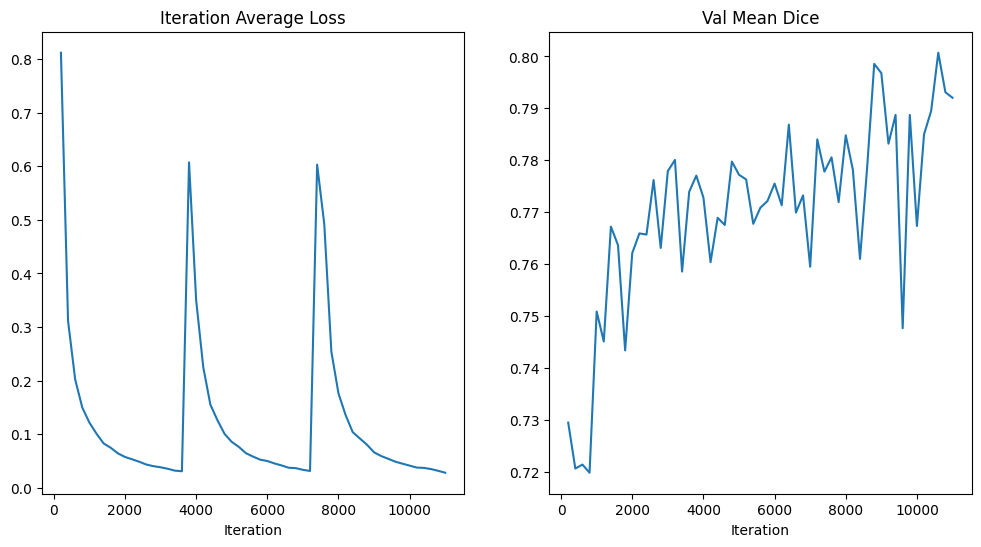

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

Load Output Model

In [18]:
# Load trained model
model.load_state_dict(torch.load(os.path.join(data_dir, "2d_latest_metric_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.5, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
              (adn): ADN(
                (N): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
                (D): Dropout(p=0.5, inplace=False)
                (A): PReLU(num_parameters=1)
              )

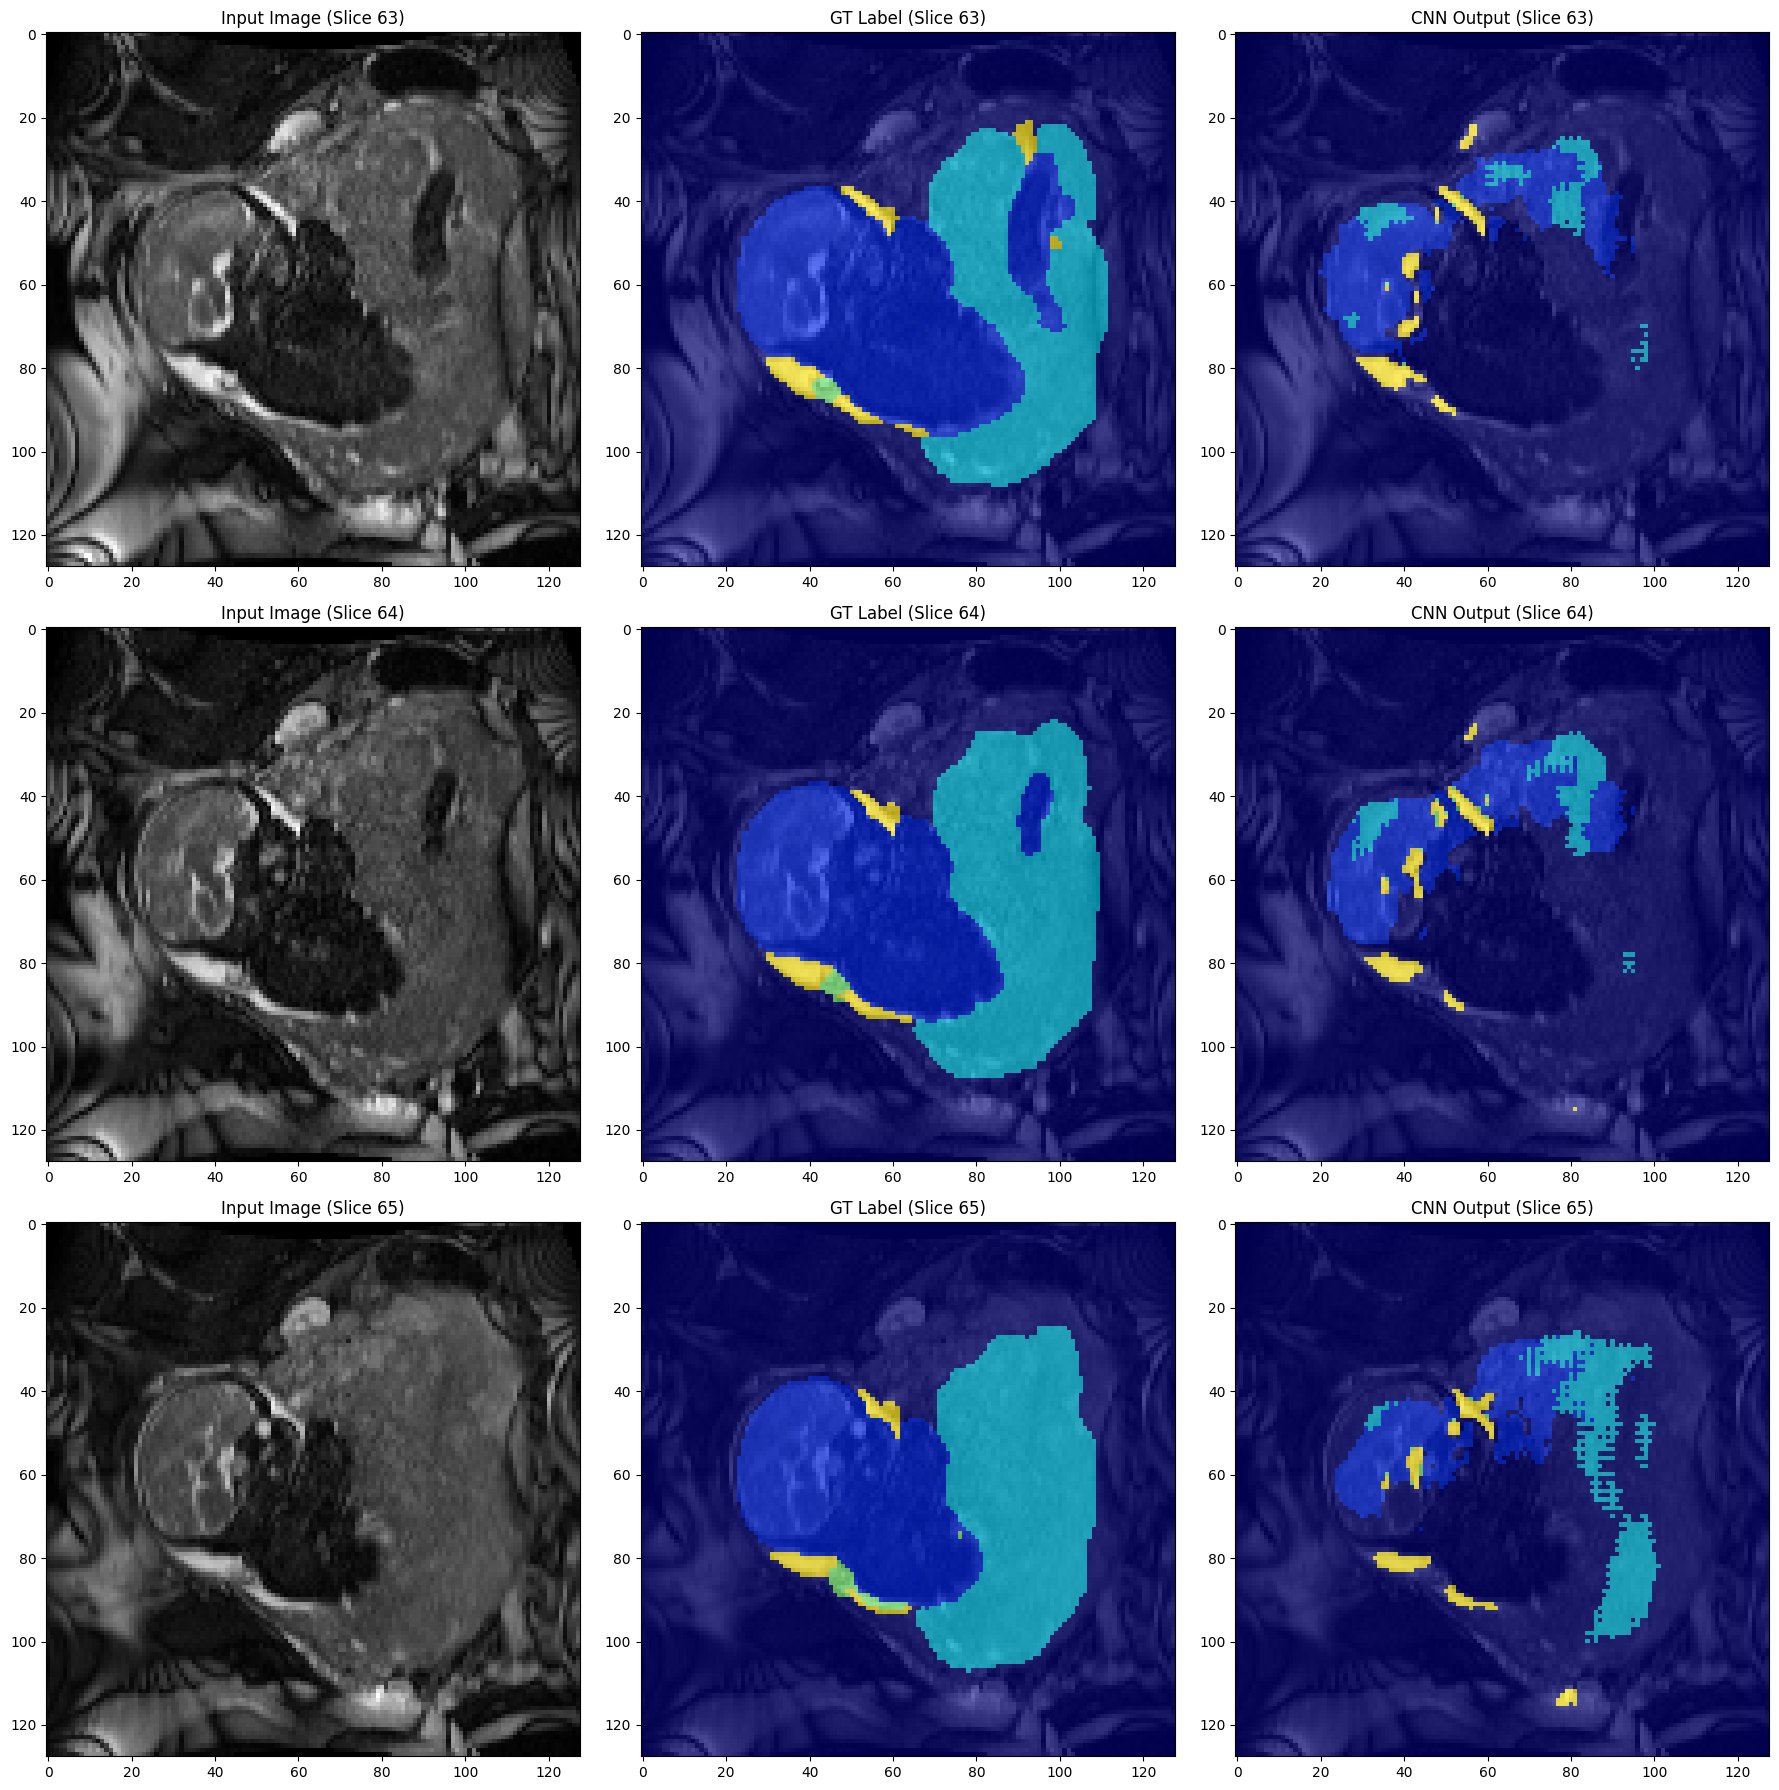

In [19]:
import matplotlib.pyplot as plt
import torch

case_num = 1
class_n = 6
alpha_val = 0.6

# Pick center slice in z (axial plane)
qq = val_volume_ds[case_num]["image"].shape[-1] // 2

with torch.no_grad():
    val_case_data = val_volume_ds[case_num]

    val_inputs = val_case_data["image"].unsqueeze(0).to(device)  # [1, 1, H, W, D]
    val_labels = val_case_data["label"].unsqueeze(0).to(device)  # [1, 1, H, W, D]

    # Predict slice-by-slice
    pred_slices = []
    for slice_idx in range(val_inputs.shape[-1]):  # loop over D axis
        input_slice = val_inputs[..., slice_idx]  # [1, 1, H, W]
        output_slice = sliding_window_inference(input_slice, (img_dim, img_dim), 4, model)  # 2D inference
        pred_slice = torch.argmax(output_slice, dim=1)  # [1, H, W]
        pred_slices.append(pred_slice)

    pred_labels = torch.stack(pred_slices, dim=-1).squeeze(1)  # [1, H, W, D]

    plt.figure(figsize=(18, 18))
    for i, q in enumerate([qq-1, qq, qq+1]):
        # Input image
        plt.subplot(3, 3, 1 + i * 3)
        plt.title(f"Input Image (Slice {q})")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, q], cmap="gray")

        # Ground truth label
        plt.subplot(3, 3, 2 + i * 3)
        plt.title(f"GT Label (Slice {q})")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, q], cmap="gray")
        plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, q], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")

        # CNN output label
        plt.subplot(3, 3, 3 + i * 3)
        plt.title(f"CNN Output (Slice {q})")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, q], cmap="gray")
        plt.imshow(pred_labels.cpu().numpy()[0, :, :, q], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")

    plt.tight_layout()
    plt.show()

Save CNN segmentation results for all validation images

In [20]:
model.load_state_dict(torch.load(os.path.join(data_dir, "2d_best_metric_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.5, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
              (adn): ADN(
                (N): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
                (D): Dropout(p=0.5, inplace=False)
                (A): PReLU(num_parameters=1)
              )

In [21]:
# Output predictions for all validation images
res_dir = os.path.join(data_dir, "2d_results")
os.makedirs(res_dir, exist_ok=True)

# Loop over validation cases
for case_num, case in enumerate(val_files):
    img_path = case["image"]
    label_path = case["label"]
    case_name = os.path.basename(img_path)
    out_name = os.path.join(res_dir, "2d-cnn-lab-" + case_name)

    img_meta = nib.load(img_path)

    with torch.no_grad():
        # Get data for the current case from val_volume_ds
        val_case_data = val_volume_ds[case_num]

        # Extract image and add batch and channel dimensions
        val_inputs = val_case_data["image"].unsqueeze(0).unsqueeze(0).to(device)

        # Perform sliding window inference on 2D slices
        val_outputs = []
        for slice_index in range(val_inputs.shape[-1]):
            slice_input = val_inputs[..., slice_index].squeeze(2)
            slice_output = model(slice_input)  # No sliding inference, just forward pass
            val_outputs.append(slice_output)


        val_outputs = torch.stack(val_outputs, dim=-1)
        out_label = torch.argmax(val_outputs, dim=1).cpu().numpy()
        out_label = out_label[0]  # shape [H, W, D]
        # print(out_label.shape)

        out_nii = nib.Nifti1Image(out_label, img_meta.affine, img_meta.header)
        nib.save(out_nii, out_name)

In [ ]:
import torch
import numpy as np
import nibabel as nib
from monai.metrics import DiceMetric

# Setup
results_dir = res_dir # your saved CNN segmentations folder
num_classes = 5     # set how many classes you have (including background or not)

dice_scores = []
volume_differences = []

for case_idx in range(len(val_files)):
    # Load ground truth and prediction
    label_path = val_files[case_idx]["label"]
    pred_path = os.path.join(results_dir, "2d-cnn-lab-" + os.path.basename(val_files[case_idx]["image"]))

    gt = nib.load(label_path).get_fdata().astype(np.uint8)
    pred = nib.load(pred_path).get_fdata().astype(np.uint8)

    # Confirm shapes match
    if gt.shape != pred.shape:
        print(f"Warning: Shape mismatch in case {case_idx}: {gt.shape} vs {pred.shape}")
        continue

    # One-hot encode
    gt_onehot = np.zeros((num_classes, *gt.shape), dtype=np.uint8)
    pred_onehot = np.zeros((num_classes, *pred.shape), dtype=np.uint8)

    for c in range(num_classes):
        gt_onehot[c] = (gt == c)
        pred_onehot[c] = (pred == c)

    gt_onehot = np.expand_dims(gt_onehot, axis=0)  # [B, C, H, W, D]
    pred_onehot = np.expand_dims(pred_onehot, axis=0)

    # Dice
    dice_metric = DiceMetric(include_background=False, reduction="none")
    dice_case = dice_metric(y_pred=torch.tensor(pred_onehot), y=torch.tensor(gt_onehot))
    dice_scores.append(dice_case.cpu().numpy()[0])

    # Volume differences
    vol_gt = np.sum(gt_onehot, axis=(2,3,4))
    vol_pred = np.sum(pred_onehot, axis=(2,3,4))
    vol_diff_case = np.abs(vol_gt - vol_pred) / (vol_gt + 1e-6)
    volume_differences.append(vol_diff_case[0])

# Convert to numpy arrays
dice_scores = np.array(dice_scores)         # shape [N_cases, N_classes]
volume_differences = np.array(volume_differences) # shape [N_cases, N_classes]

print("Dice scores shape:", dice_scores.shape)
print("Volume differences shape:", volume_differences.shape)

np.save("dice_scores_2d.npy", dice_scores)
np.save("volume_differences_2d.npy", volume_differences)

Dice scores shape: (0,)
Volume differences shape: (0,)
